# Imports

In [1616]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
from ucimlrepo import fetch_ucirepo
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lime.lime_tabular
import shap
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from DatasetAnalysis import DatasetAnalysis
from PerformanceAnalysis import PerformanceAnalysis
from Visualization import Visualization

# Setup

In [1617]:
config_file = open("config.json")
config_vars = json.load(config_file)
config_file.close()

#logs_dir = config_vars["logs_dir"]
logs_dir = "./th_70/intersect"

In [1618]:
config_file = open("visual_config.json")
visual_vars = json.load(config_file)
config_file.close()

shap_colors_neg = visual_vars["shap_colors"]["negative"]
shap_colors_pos = visual_vars["shap_colors"]["positive"]
shap_colors = np.array([tuple(shap_colors_neg), tuple(shap_colors_pos)])

title_size = visual_vars["title_font_size"]
label_size = visual_vars["labels_font_size"]

green_color = tuple([x/255 for x in visual_vars["green_colors"]["c2"]])

suffix = "70_intersect"

# Get Dataset

In [1619]:
dataset = pd.read_csv("datasets/DARWIN.csv", header=0)
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

In [1620]:
y

0      P
1      P
2      P
3      P
4      P
      ..
169    H
170    H
171    H
172    H
173    H
Name: class, Length: 174, dtype: object

###### Obtain Dataset From Repository

In [1621]:
# # fetch dataset 
# darwin = fetch_ucirepo(id=732)
#   
# # data (as pandas dataframes)
# X = darwin.data.features
# y = darwin.data.targets
#   
# # metadata 
# print(darwin.metadata)
# 
# # variable information
# print(darwin.variables)

In [1622]:
data_analysis = DatasetAnalysis()

In [1623]:
np.unique(y)

array(['H', 'P'], dtype=object)

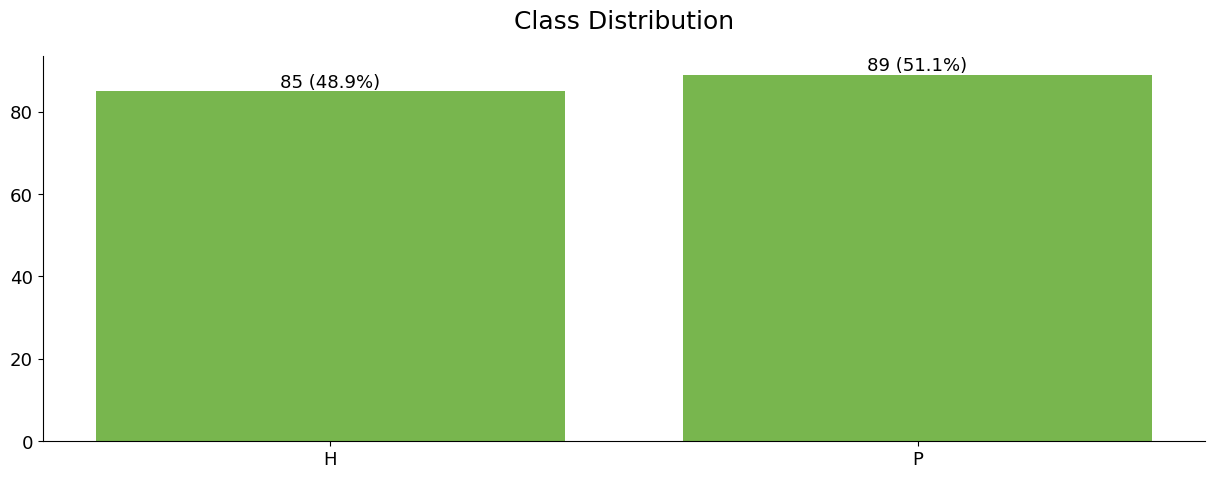

In [1624]:
plt.figure(figsize=(15, 5))

data_analysis.class_dist(y, title="Class Distribution", colors=green_color, label_font_size=label_size)

plt.savefig(f"{logs_dir}/darwin_class_dist.png", bbox_inches="tight")
plt.show()

In [1625]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

In [1626]:
from sklearn.compose import ColumnTransformer
print(f"Numerical Columns - {len(numerical_columns)}\n\n {numerical_columns}")
print(f"\n\n\nCategorical Columns - {len(categorical_columns)}\n\n {categorical_columns}")

Numerical Columns - 450

 ['air_time1', 'disp_index1', 'gmrt_in_air1', 'gmrt_on_paper1', 'max_x_extension1', 'max_y_extension1', 'mean_acc_in_air1', 'mean_acc_on_paper1', 'mean_gmrt1', 'mean_jerk_in_air1', 'mean_jerk_on_paper1', 'mean_speed_in_air1', 'mean_speed_on_paper1', 'num_of_pendown1', 'paper_time1', 'pressure_mean1', 'pressure_var1', 'total_time1', 'air_time2', 'disp_index2', 'gmrt_in_air2', 'gmrt_on_paper2', 'max_x_extension2', 'max_y_extension2', 'mean_acc_in_air2', 'mean_acc_on_paper2', 'mean_gmrt2', 'mean_jerk_in_air2', 'mean_jerk_on_paper2', 'mean_speed_in_air2', 'mean_speed_on_paper2', 'num_of_pendown2', 'paper_time2', 'pressure_mean2', 'pressure_var2', 'total_time2', 'air_time3', 'disp_index3', 'gmrt_in_air3', 'gmrt_on_paper3', 'max_x_extension3', 'max_y_extension3', 'mean_acc_in_air3', 'mean_acc_on_paper3', 'mean_gmrt3', 'mean_jerk_in_air3', 'mean_jerk_on_paper3', 'mean_speed_in_air3', 'mean_speed_on_paper3', 'num_of_pendown3', 'paper_time3', 'pressure_mean3', 'pressure

The only categorical column is 'ID' which has no relevance for classification because is just an identifier of each experiment, so it will be dropped

In [1627]:
X = X.drop(columns=["ID"])

## Features chosen 95% of the time

In [1628]:
idx_fcbf_95 = [24,83,88,117,162,178,243,261,270,271,289,303,340,360,366,371,376,396,401,414,432]
idx_fisher_95 = [54,108,111,117,120,159,162,234,270,271,288,291,292,295,297,298,300,380,398,399,408,444]
idx_union_95 = [24,54,83,88,108,111,117,120,159,162,178,234,243,261,270,271,288,289,291,292,295,297,298,300,303,340,360,366,371,376,380,396,398,399,401,408,414,432,444]
idx_intersect_95 = [117, 162, 270, 271]

print(f"FCBF:      {len(idx_fcbf_95)}\nFisher:    {len(idx_fisher_95)}\nUnion:     {len(idx_union_95)}\nIntersect: {len(idx_intersect_95)}")

FCBF:      21
Fisher:    22
Union:     39
Intersect: 4


## Features chosen 90% of the time

In [1629]:
idx_fcbf_90 = [24, 54, 74, 83, 88, 117, 162, 178, 243, 261, 270, 271, 289, 303, 340, 360, 366, 371, 376, 396, 401, 414, 432]
idx_fisher_90 = [54, 108, 111, 117, 120, 159, 162, 234, 270, 271, 288, 291, 292, 295, 297, 298, 300, 380, 398, 399, 408, 444]
idx_union_90 = [24, 54, 74, 83, 88, 108, 111, 117, 120, 159, 162, 178, 234, 243, 261, 270, 271, 288, 289, 291, 292, 295, 297, 298, 300, 303, 340, 360, 366, 371, 376, 380, 396, 398, 399, 401, 408, 414, 432, 444]
idx_intersect_90 = [54, 117, 162, 270, 271]

print(f"FCBF:      {len(idx_fcbf_90)}\nFisher:    {len(idx_fisher_90)}\nUnion:     {len(idx_union_90)}\nIntersect: {len(idx_intersect_90)}")

FCBF:      23
Fisher:    22
Union:     40
Intersect: 5
[54, 117, 162, 270, 271]


## Features chosen 80% of the time

In [1630]:
idx_fcbf_80 = [24, 54, 70, 74, 83, 88, 91, 117, 152, 162, 178, 234, 243, 261, 270, 271, 289, 303, 340, 360, 366, 371, 376, 396, 401, 414, 432, 436]
idx_fisher_80 = [54, 89, 108, 111, 117, 120, 159, 162, 234, 270, 271, 288, 291, 292, 295, 297, 298, 300, 380, 398, 399, 408, 444]
idx_union_80 = [24, 54, 70, 74, 83, 88, 89, 91, 108, 111, 117, 120, 152, 159, 162, 178, 234, 243, 261, 270, 271, 288, 289, 291, 292, 295, 297, 298, 300, 303, 340, 360, 366, 371, 376, 380, 396, 398, 399, 401, 408, 414, 432, 436, 444]
idx_intersect_80 = [54, 117, 162, 234, 270, 271]

print(f"FCBF:      {len(idx_fcbf_80)}\nFisher:    {len(idx_fisher_80)}\nUnion:     {len(idx_union_80)}\nIntersect: {len(idx_intersect_80)}")

FCBF:      28
Fisher:    23
Union:     45
Intersect: 6


## Features chosen 70% of the time

In [1631]:
idx_fcbf_70 = [24, 46, 54, 70, 74, 83, 88, 91, 105, 117, 138, 152, 162, 178, 234, 243, 261, 270, 271, 289, 303, 324, 330, 340, 360, 366, 371, 376, 396, 401, 414, 432, 434, 436]
idx_fisher_70 = [36, 54, 89, 108, 111, 117, 120, 159, 162, 234, 267, 270, 271, 288, 291, 292, 295, 297, 298, 300, 380, 398, 399, 408, 444]
idx_union_70 = [24, 36, 46, 54, 70, 74, 83, 88, 89, 91, 105, 108, 111, 117, 120, 138, 152, 159, 162, 178, 234, 243, 261, 267, 270, 271, 288, 289, 291, 292, 295, 297, 298, 300, 303, 324, 330, 340, 360, 366, 371, 376, 380, 396, 398, 399, 401, 408, 414, 432, 434, 436, 444]
idx_intersect_70 = [54, 117, 162, 234, 270, 271]

print(f"FCBF:      {len(idx_fcbf_70)}\nFisher:    {len(idx_fisher_70)}\nUnion:     {len(idx_union_70)}\nIntersect: {len(idx_intersect_70)}")

FCBF:      34
Fisher:    25
Union:     53
Intersect: 6


In [1632]:
X = X.iloc[:, idx_intersect_70]

In [1633]:
features_names = X.columns

In [1634]:
#Convert from pandas to numpy and turn into a 1D array
y = y.to_numpy().ravel()
y = [0 if x == 'H' else 1 for x in y]
y

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [1635]:
X_train_pd, X_test_pd, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train = X_train_pd.to_numpy()
X_test = X_test_pd.to_numpy()

## Instance to extract local explanations for all models

In [1636]:
Exp_index = 18
Exp_inst = X_test[Exp_index, :]
Exp_inst_pd = X_test_pd.iloc[Exp_index, :]
Exp_inst_class = Y_test[Exp_index]

for i in range(len(Exp_inst_pd)):
    print(f"{Exp_inst_pd.index[i]}  {Exp_inst_pd.iloc[i]}")

print(f"\n\nClass: {Exp_inst_class}")

air_time4  9580.0
mean_jerk_in_air7  0.197188169
air_time10  1165.0
air_time14  4110.0
air_time16  13415.0
disp_index16  5.44e-06


Class: 1


# Classification

In [1637]:
perf_analysis = PerformanceAnalysis()

## <i>Logistic Regression</i> (LR)

In [1638]:
lr_init_t = time.time()
lr_clf = LogisticRegression(solver="lbfgs", max_iter=500, C=0.01, random_state=42).fit(X_train, Y_train)
lr_fin_t = time.time()
lr_duration = lr_fin_t - lr_init_t

Metrics                Values
accuracy             0.571429
false-positive rate  1.000000
false-negative rate  0.000000
precision            0.571429
recall               1.000000
f-score              0.727273

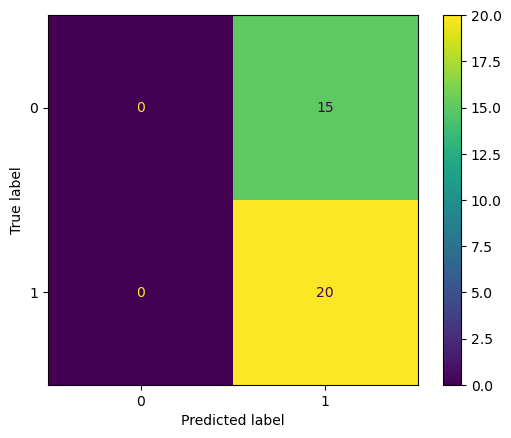

In [1639]:
lr_ye = lr_clf.predict(X_test)

lr_cm = confusion_matrix(Y_test, lr_ye)
lr_metrics = perf_analysis.compute_metrics(lr_cm)
display(lr_metrics)

ConfusionMatrixDisplay.from_predictions(Y_test, lr_ye)

lr_y2d = lr_clf.predict_proba(X_test)[:, 1]

plt.show()

In [1640]:
lr_clf.predict([Exp_inst])

array([1])

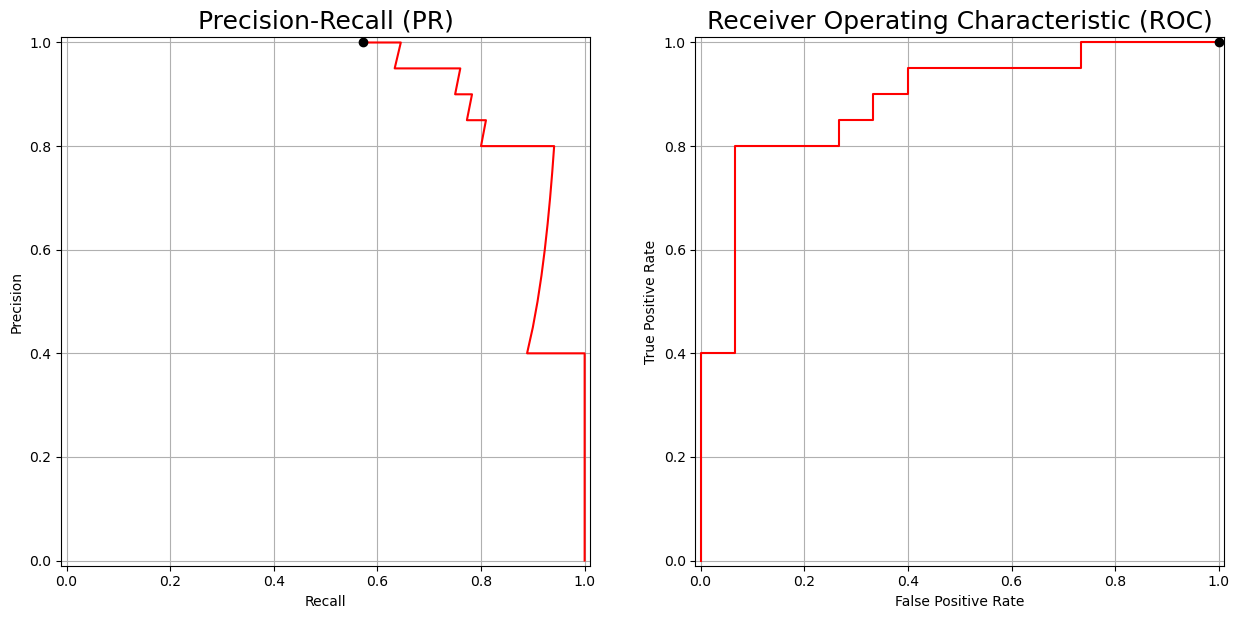

In [1641]:
plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
perf_analysis.plot_PR(Y_test, lr_cm, lr_y2d)

plt.subplot(1,2,2)
perf_analysis.plot_ROC(Y_test, lr_cm, lr_y2d)

plt.show()

### Extract Explanations

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [1642]:
lr_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names, random_state=42)
lr_LIME_explanation = lr_LIME_explainer.explain_instance(Exp_inst, lr_clf.predict_proba)

In [1643]:
lr_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [1644]:
shap.initjs()

In [1645]:
lr_shap_init_t = time.time()
lr_SHAP_exp = shap.KernelExplainer(lr_clf.predict_proba, shap.sample(X_train_pd, 20, random_state=42), random_state=42)
lr_shap_loc_values = np.array(lr_SHAP_exp.shap_values(Exp_inst_pd))

In [1646]:
shap.force_plot(lr_SHAP_exp.expected_value[1], lr_shap_loc_values[1, :], Exp_inst_pd)

#### Global (SHAP)

In [1647]:
lr_shap_global_values = lr_SHAP_exp.shap_values(X_test_pd)

  0%|          | 0/35 [00:00<?, ?it/s]

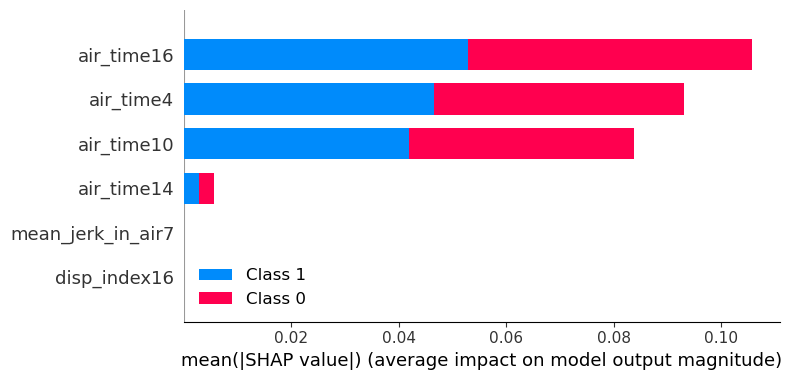

In [1648]:
shap.summary_plot(lr_shap_global_values, X_test_pd, plot_type="bar")
lr_shap_fin_t = time.time()
lr_shap_dur = lr_shap_fin_t - lr_shap_init_t

## <i>Random Forest</i> (RF)

In [1649]:
rf_init_t = time.time()
rf_clf = RandomForestClassifier(n_estimators=100, bootstrap=False, max_features="log2", random_state=42).fit(X_train, Y_train)
rf_fin_t = time.time()
rf_duration = rf_fin_t - rf_init_t

Metrics                Values
accuracy             0.771429
false-positive rate  0.200000
false-negative rate  0.250000
precision            0.833333
recall               0.750000
f-score              0.789474

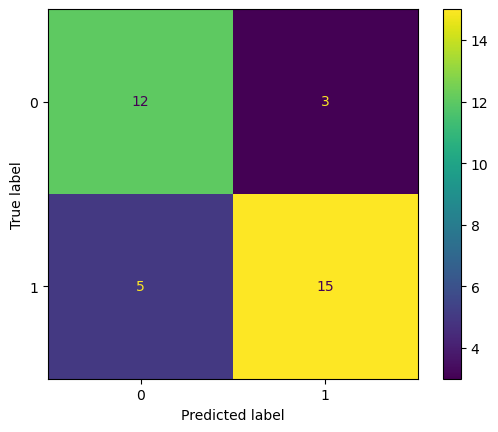

In [1650]:
rf_ye = rf_clf.predict(X_test)

rf_cm = confusion_matrix(Y_test, rf_ye)
rf_metrics = perf_analysis.compute_metrics(rf_cm)
display(rf_metrics)

ConfusionMatrixDisplay.from_predictions(Y_test, rf_ye)

rf_y2d = rf_clf.predict_proba(X_test)[:, 1]

plt.show()

In [1651]:
rf_clf.predict([Exp_inst])

array([1])

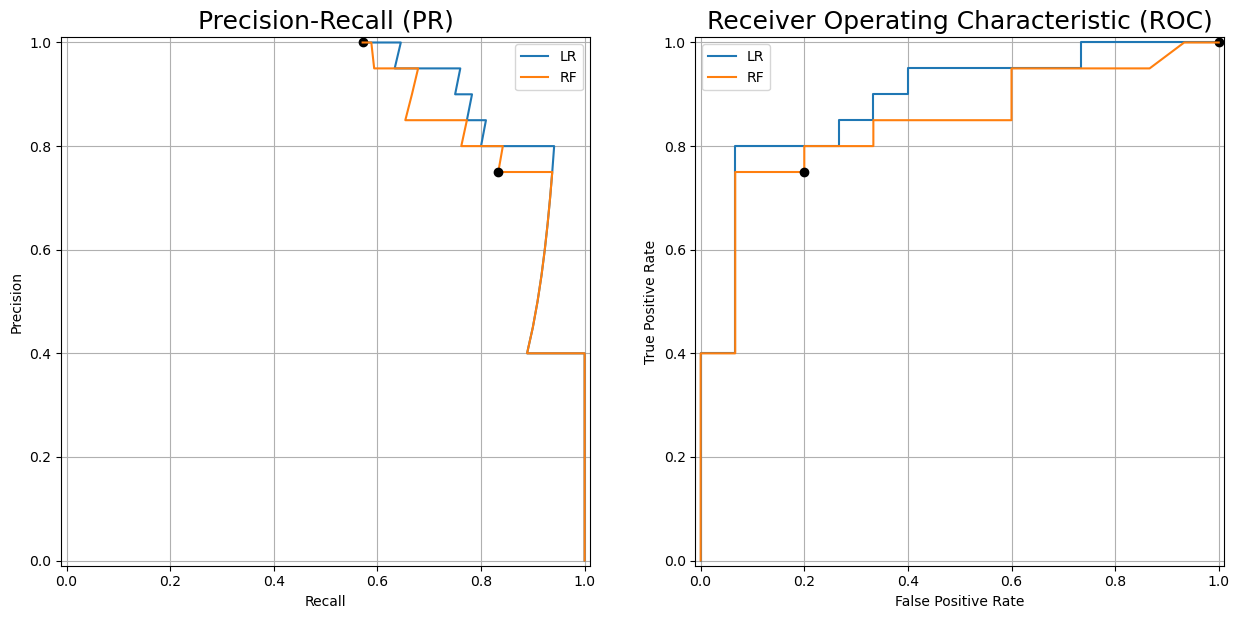

In [1652]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
perf_analysis.compare_PR([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR", "RF"])

plt.subplot(1,2,2)
perf_analysis.compare_ROC([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR","RF"])


plt.show()

### Extract Explanations 

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [1653]:
rf_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names, random_state=42)
rf_LIME_explanation = rf_LIME_explainer.explain_instance(Exp_inst, rf_clf.predict_proba)

In [1654]:
rf_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [1655]:
rf_shap_init_t = time.time()
rf_SHAP_exp = shap.TreeExplainer(rf_clf, random_state=42)
rf_shap_loc_values = np.array(rf_SHAP_exp.shap_values(Exp_inst_pd))

In [1656]:
shap.force_plot(rf_SHAP_exp.expected_value[1], rf_shap_loc_values[1, :], Exp_inst_pd)

#### Global (SHAP)

In [1657]:
rf_shap_global_values = rf_SHAP_exp.shap_values(X_test_pd)

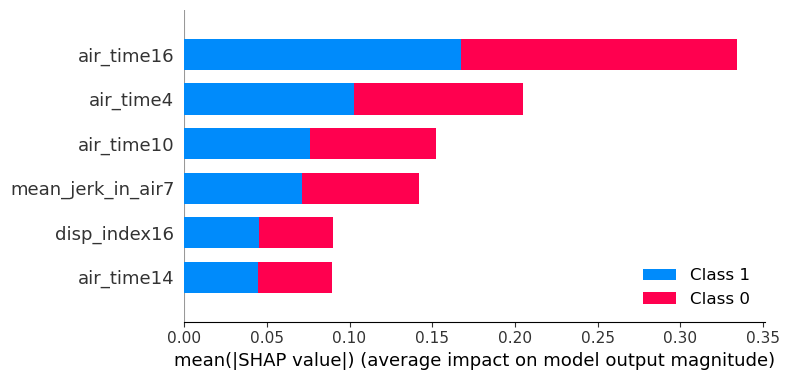

In [1658]:
shap.summary_plot(rf_shap_global_values, X_test_pd, plot_type="bar")
rf_shap_fin_t = time.time()
rf_shap_dur = rf_shap_fin_t - rf_shap_init_t

## <i> Support Vector Machines</i> (SVM)

In [1659]:
#(probability=True) gives the possibility to use the predict_proba() method, which is used to extract explanations
svm_init_t = time.time()
svm_clf = SVC(kernel="rbf", decision_function_shape="ovr", gamma="scale", C=500, probability=True, random_state=42).fit(X_train, Y_train)
svm_fin_t = time.time()
svm_duration = svm_fin_t - svm_init_t

Metrics                Values
accuracy             0.857143
false-positive rate  0.133333
false-negative rate  0.150000
precision            0.894737
recall               0.850000
f-score              0.871795

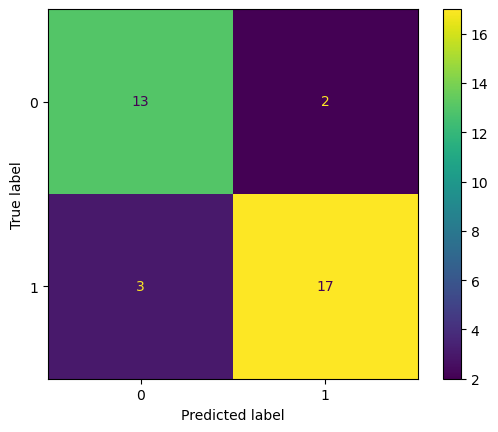

In [1660]:
svm_ye = svm_clf.predict(X_test)

svm_cm = confusion_matrix(Y_test, svm_ye)
svm_metrics = perf_analysis.compute_metrics(svm_cm)
display(svm_metrics)

ConfusionMatrixDisplay.from_predictions(Y_test, svm_ye)

svm_y2d = svm_clf.decision_function(X_test)

plt.show()

In [1661]:
svm_clf.predict([Exp_inst])

array([1])

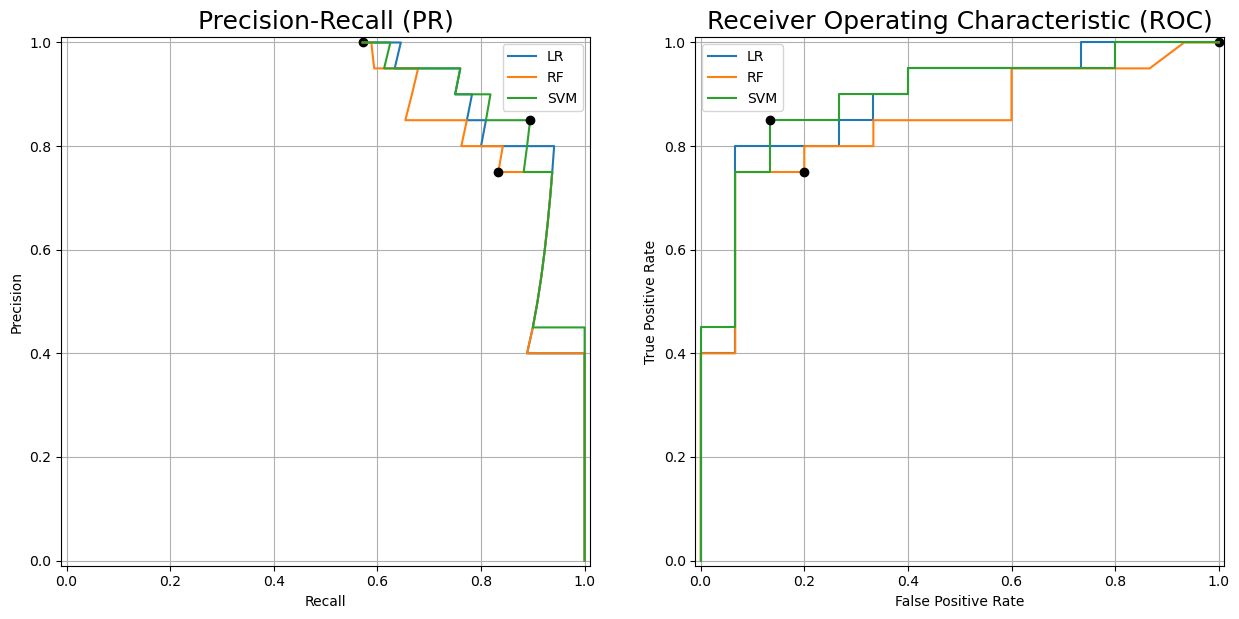

In [1662]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
perf_analysis.compare_PR([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR", "RF", "SVM"])

plt.subplot(1,2,2)
perf_analysis.compare_ROC([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR","RF", "SVM"])

plt.show()

### Extract Explanations

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [1663]:
svm_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names, random_state=42)
svm_LIME_explanation = svm_LIME_explainer.explain_instance(Exp_inst, svm_clf.predict_proba)

In [1664]:
svm_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [1665]:
svm_shap_init_t = time.time()
svm_SHAP_exp = shap.KernelExplainer(svm_clf.predict_proba, shap.sample(X_train_pd, 20, random_state=42), random_state=42)
svm_shap_loc_values = np.array(svm_SHAP_exp.shap_values(Exp_inst_pd))

In [1666]:
shap.force_plot(svm_SHAP_exp.expected_value[1], svm_shap_loc_values[1, :], Exp_inst_pd)

#### Global (SHAP)

In [1667]:
svm_shap_global_values = svm_SHAP_exp.shap_values(X_test_pd)

  0%|          | 0/35 [00:00<?, ?it/s]

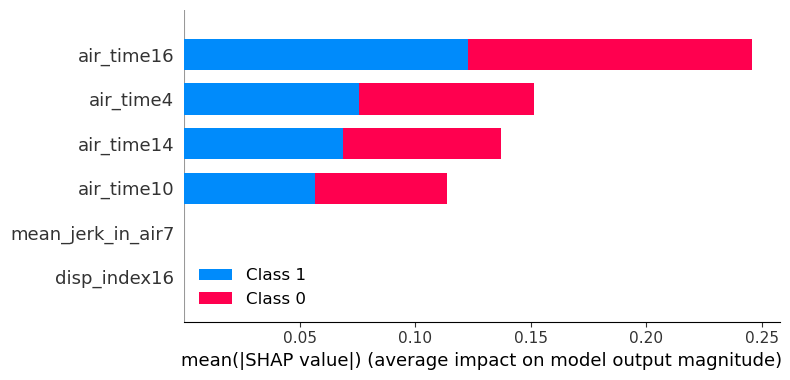

In [1668]:
shap.summary_plot(svm_shap_global_values, X_test_pd, plot_type="bar")
svm_shap_fin_t = time.time()
svm_shap_dur = svm_shap_fin_t - svm_shap_init_t

## <i>Explainable Boosting Machine</i> (EBM)

In [1669]:
ebm_init_t = time.time()
ebm_clf = ExplainableBoostingClassifier(max_bins=1024, smoothing_rounds=500, cyclic_progress=0, random_state=42).fit(X_train_pd, Y_train)
ebm_fin_t = time.time()
ebm_duration = ebm_fin_t - ebm_init_t

Metrics                Values
accuracy             0.771429
false-positive rate  0.133333
false-negative rate  0.300000
precision            0.875000
recall               0.700000
f-score              0.777778

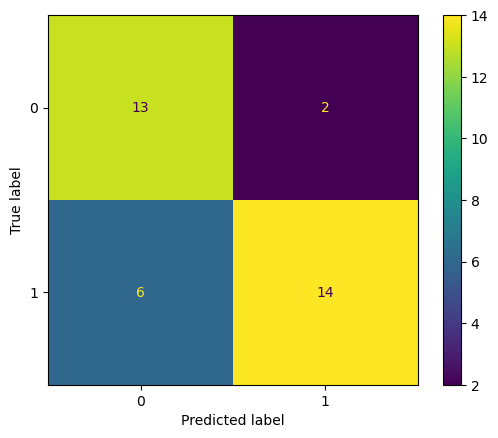

In [1670]:
ebm_ye = ebm_clf.predict(X_test_pd)

ebm_cm = confusion_matrix(Y_test, ebm_ye)
ebm_metrics = perf_analysis.compute_metrics(ebm_cm)
display(ebm_metrics)

ConfusionMatrixDisplay.from_predictions(Y_test, ebm_ye)

ebm_y2d = ebm_clf.decision_function(X_test)

plt.show()

In [1671]:
ebm_clf.predict([Exp_inst])

array([1], dtype=int64)

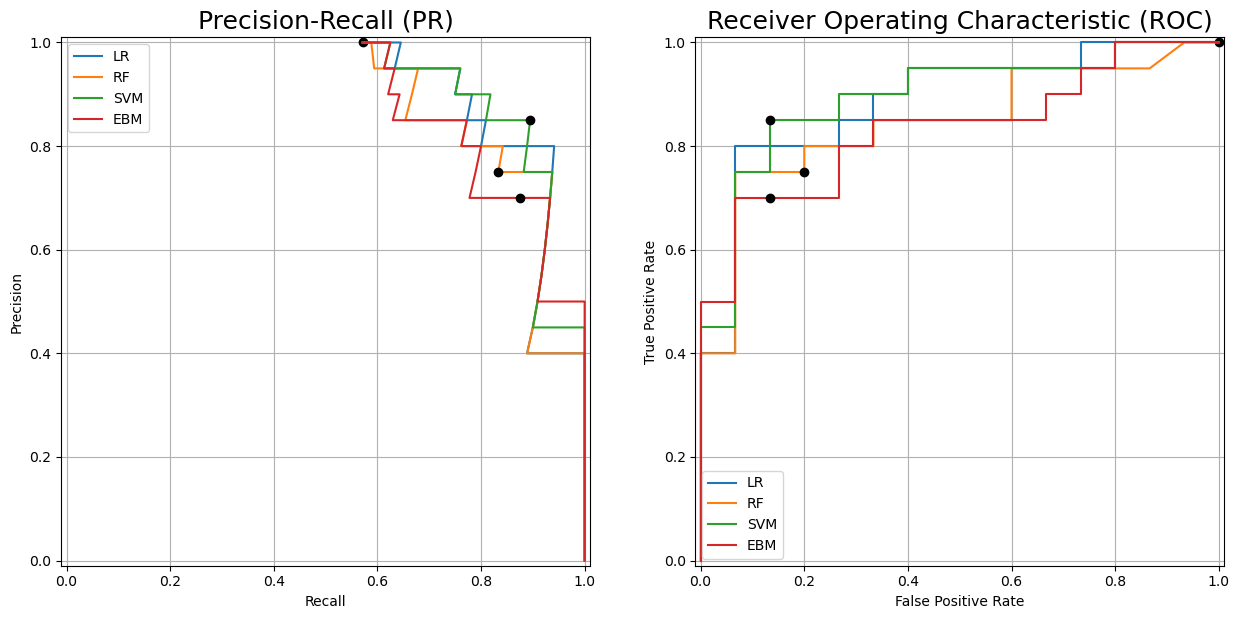

In [1672]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
perf_analysis.compare_PR([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR", "RF", "SVM", "EBM"])

plt.subplot(1,2,2)
perf_analysis.compare_ROC([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR","RF", "SVM", "EBM"])

plt.show()

### Extract Explanations

#### Local

In [1673]:
ebm_local = ebm_clf.explain_local(X_test, Y_test)
show(ebm_local)

<!-- http://127.0.0.1:7001/1909399228304/ -->

#### Global

In [1674]:
ebm_global = ebm_clf.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/1909228267088/ -->

# Summary

In [1675]:
visual = Visualization()

## Time

In [1676]:
time_pd_cols = ["LR", "RF", "SVM", "EBM"]
fit_durs = [round(x, 1) for x in [lr_duration, rf_duration, svm_duration, ebm_duration]]
shap_durs = [round(x, 1) for x in [lr_shap_dur, rf_shap_dur, svm_shap_dur]]
pd_vals = [fit_durs, shap_durs]

duration_summary = pd.DataFrame(pd_vals, columns=time_pd_cols, index=["Fit", "SHAP"])
duration_summary.columns.names = ["Task"]
duration_summary

Task   LR   RF  SVM  EBM
Fit   0.0  0.2  0.0  1.3
SHAP  1.5  1.8  2.1  NaN

In [1677]:
latex_str = duration_summary.columns.name + "".join([" & " + x for x in duration_summary.columns]) + " \\\ \n"
for i, row in duration_summary.iterrows():

    aux_str = i
    for k in row:
        aux_str += f" & {k}"

    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/darwin_duration_{suffix}.txt", "w") as text_file:
    print(latex_str, file=text_file)

## Metrics

In [1678]:
lr_metrics = lr_metrics.rename(columns={"Values": "LR"})
lr_metrics["LR"] = [round(x, 2) for x in lr_metrics["LR"]]
rf_metrics = rf_metrics.rename(columns={"Values": "RF"})
rf_metrics["RF"] = [round(x, 2) for x in rf_metrics["RF"]]
svm_metrics = svm_metrics.rename(columns={"Values": "SVM"})
svm_metrics["SVM"] = [round(x, 2) for x in svm_metrics["SVM"]]
ebm_metrics = ebm_metrics.rename(columns={"Values": "EBM"})
ebm_metrics["EBM"] = [round(x, 2) for x in ebm_metrics["EBM"]]

overall_metrics = pd.concat([lr_metrics, rf_metrics, svm_metrics, ebm_metrics], axis=1)
display(overall_metrics)

Metrics                LR    RF   SVM   EBM
accuracy             0.57  0.77  0.86  0.77
false-positive rate  1.00  0.20  0.13  0.13
false-negative rate  0.00  0.25  0.15  0.30
precision            0.57  0.83  0.89  0.88
recall               1.00  0.75  0.85  0.70
f-score              0.73  0.79  0.87  0.78

##### Build LaTeX table format

In [1679]:
latex_str = overall_metrics.columns.name  + ''.join([" & " + x for x in overall_metrics.columns]) + " \\\ \n"

In [1680]:
for i, row in overall_metrics.iterrows():
    
    aux_str = i
    for k in row:
        aux_str += f" & {k}"
    
    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/darwin_metrics_{suffix}.txt", "w") as text_file:
    print(latex_str, file=text_file)

## Confusion Matrices

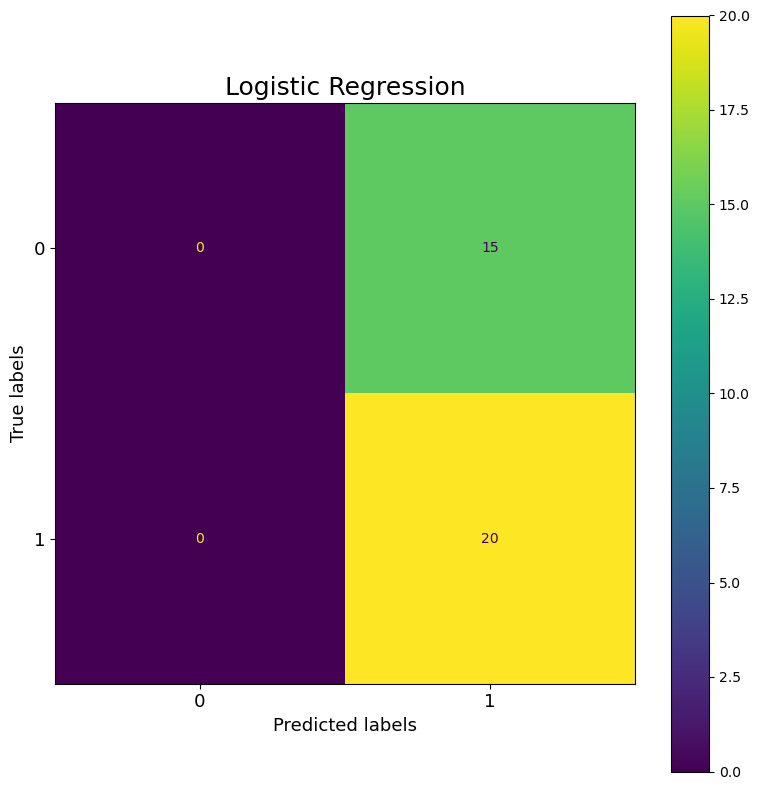

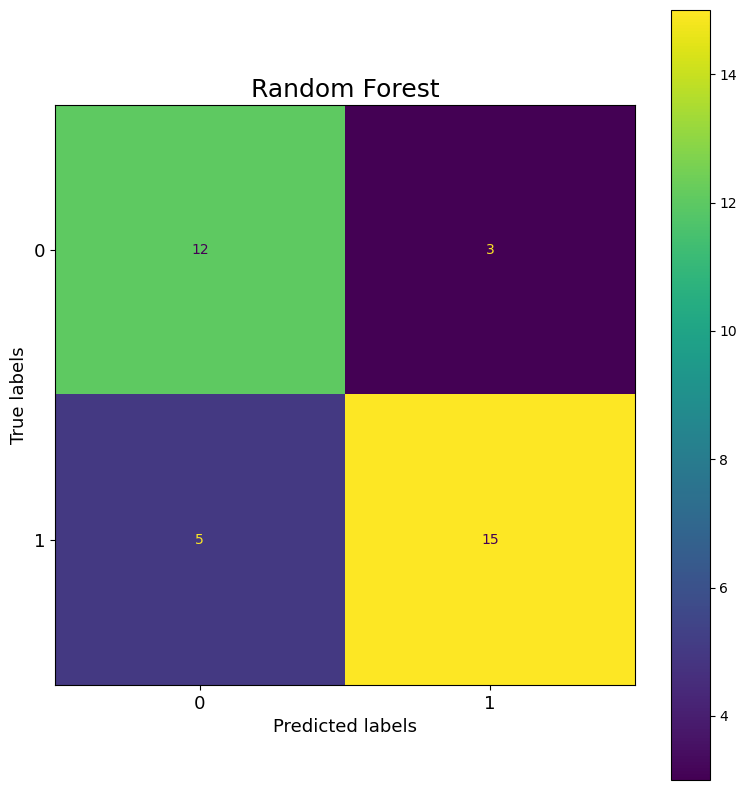

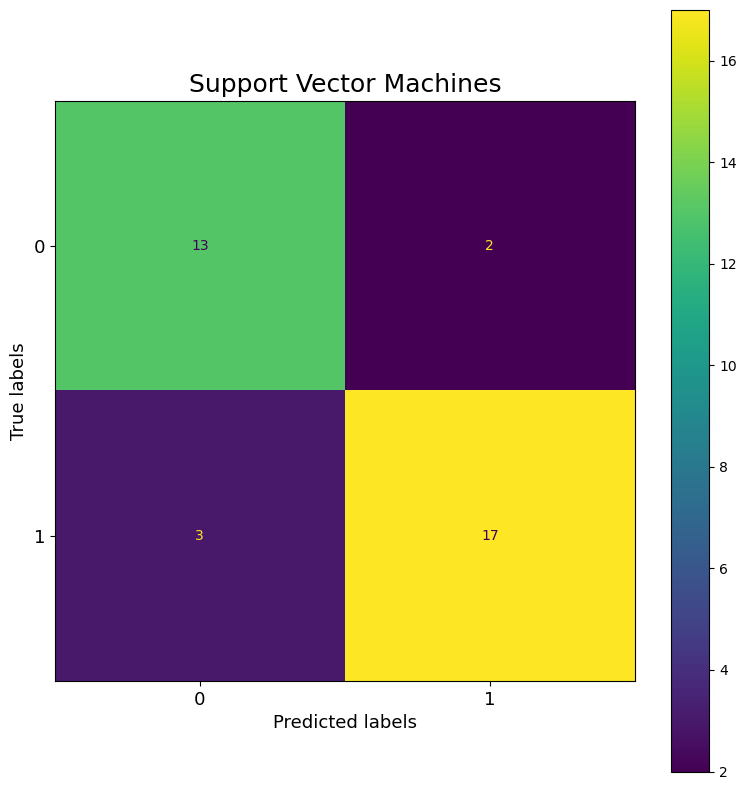

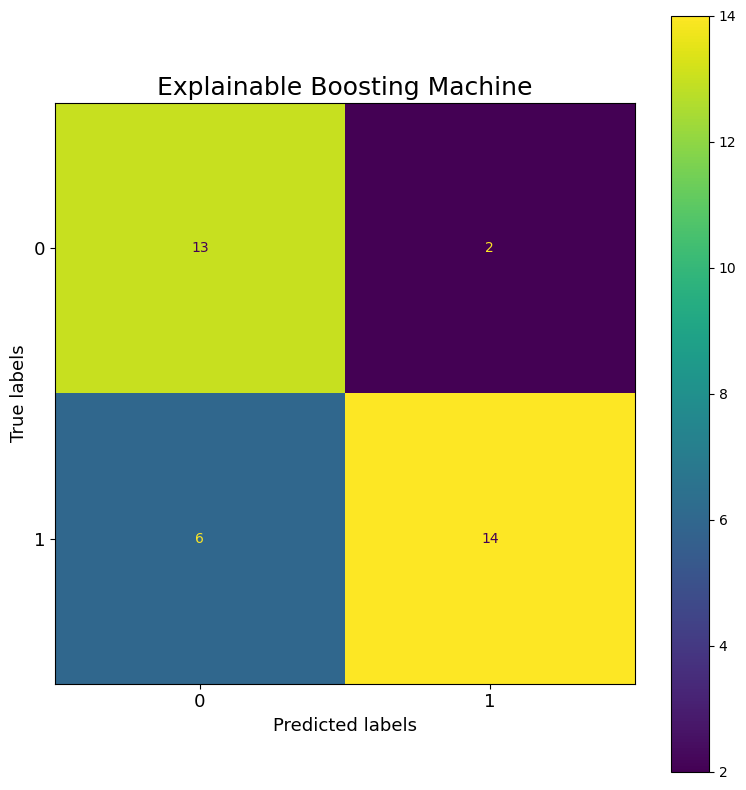

In [1681]:
visual.confusion_matrices_pred([Y_test, Y_test, Y_test, Y_test], 
                          [lr_ye, rf_ye, svm_ye, ebm_ye],
                          nrows=2, 
                          ncols=2, 
                          figsize=(8, 8),
                          title_size=title_size,
                          label_size=label_size,
                          titles=["Logistic Regression", "Random Forest", "Support Vector Machines", "Explainable Boosting Machine"],
                          save_name=f"{logs_dir}/darwin_conf_matrices_{suffix}"
                          )

# plt.savefig(f"{logs_dir}/darwin_conf_matrices_95.png", bbox_inches="tight")

plt.show()

## Curves

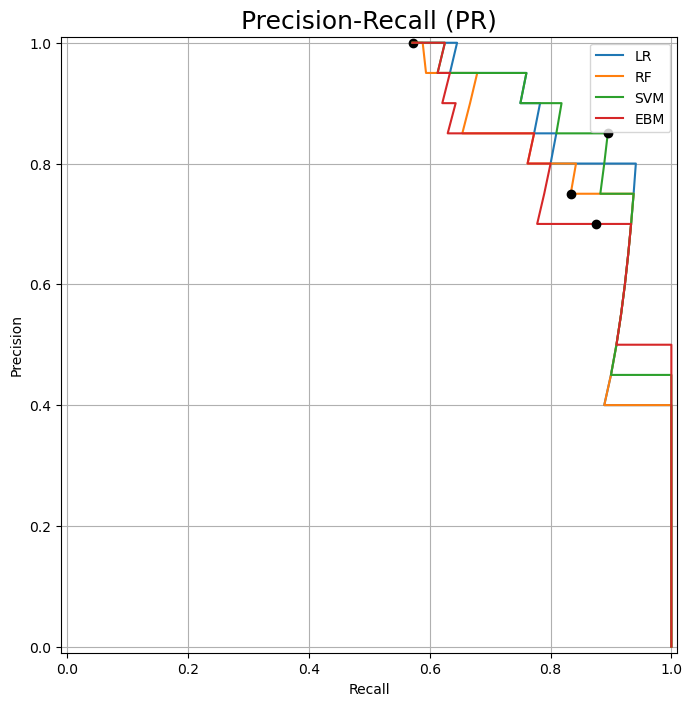

In [1682]:
plt.figure(figsize=(8, 8))

perf_analysis.compare_PR([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR", "RF", "SVM", "EBM"])

plt.savefig(f"{logs_dir}/darwin_PR_{suffix}.png", bbox_inches="tight")

plt.show()

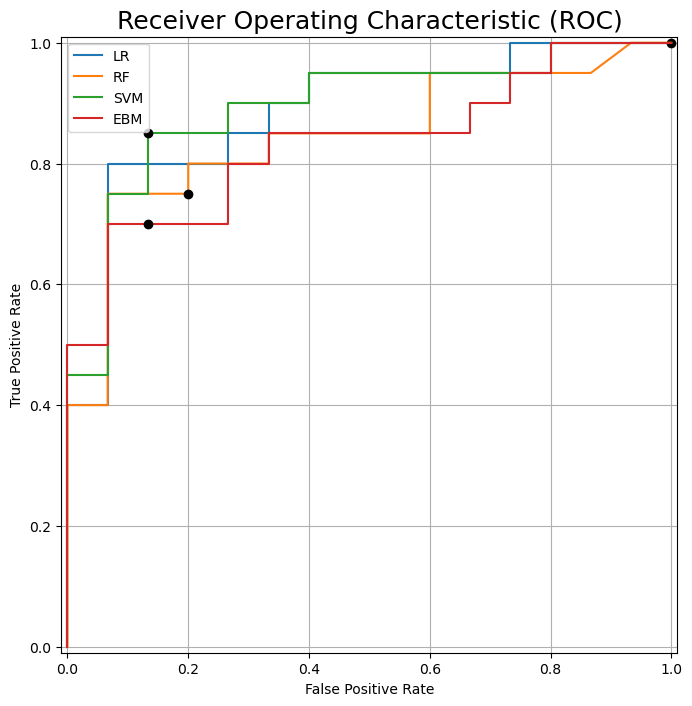

In [1683]:
plt.figure(figsize=(8, 8))

perf_analysis.compare_ROC([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR","RF", "SVM", "EBM"])

plt.savefig(f"{logs_dir}/darwin_ROC_{suffix}.png", bbox_inches="tight")

plt.show()

## Local Explanations

### LIME

In [1684]:
lr_LIME_explanation.show_in_notebook(show_table=True)
lr_LIME_explanation.save_to_file(f"{logs_dir}/darwin_LR_LIME_{suffix}.html")

In [1685]:
rf_LIME_explanation.show_in_notebook(show_table=True)
rf_LIME_explanation.save_to_file(f"{logs_dir}/darwin_RF_LIME_{suffix}.html")

In [1686]:
svm_LIME_explanation.show_in_notebook(show_table=True)
svm_LIME_explanation.save_to_file(f"{logs_dir}/darwin_SVM_LIME_{suffix}.html")

### SHAP & EBM

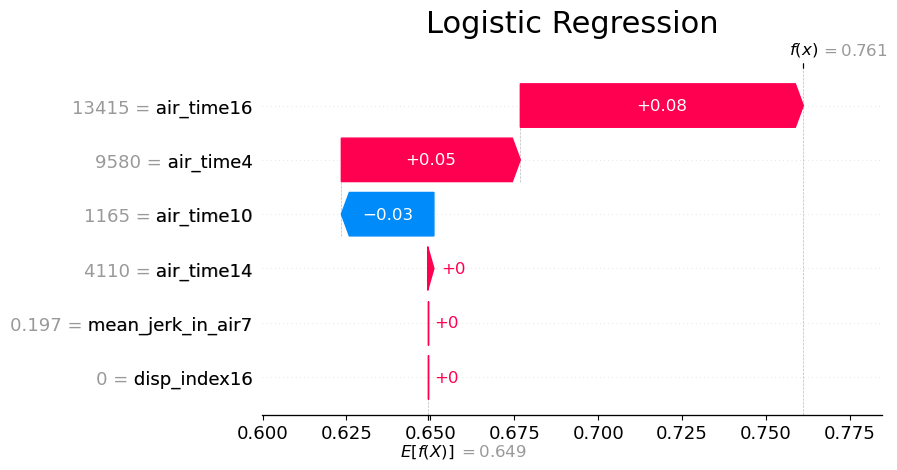

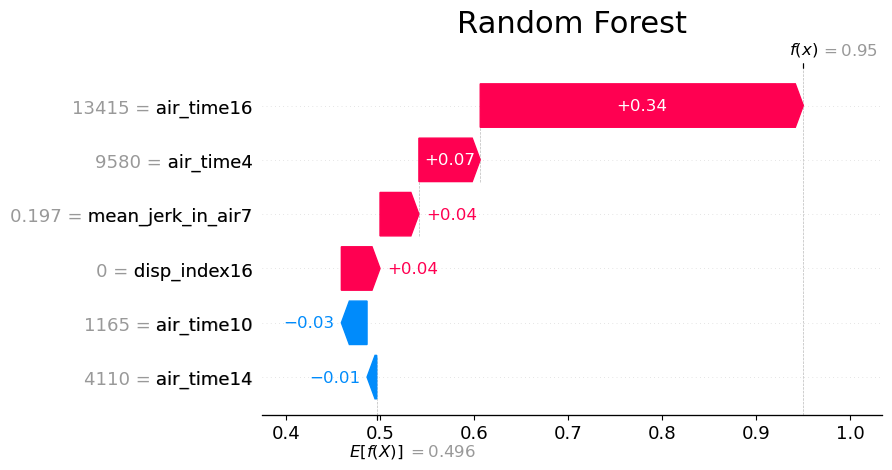

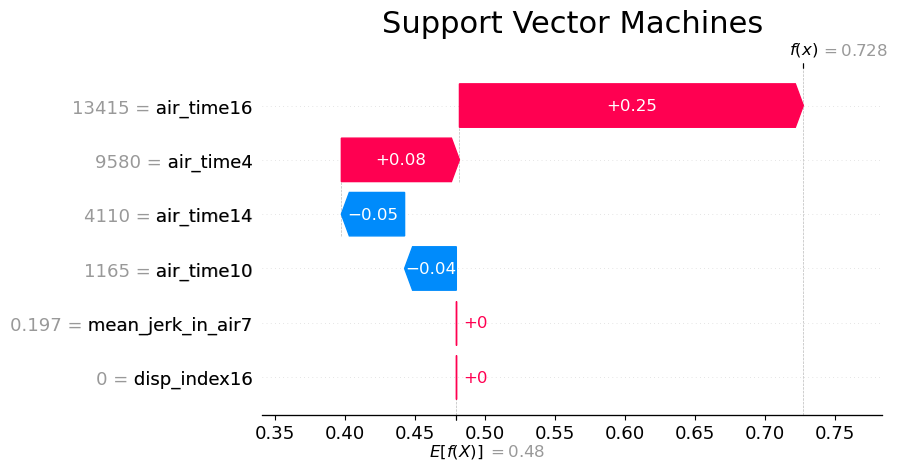

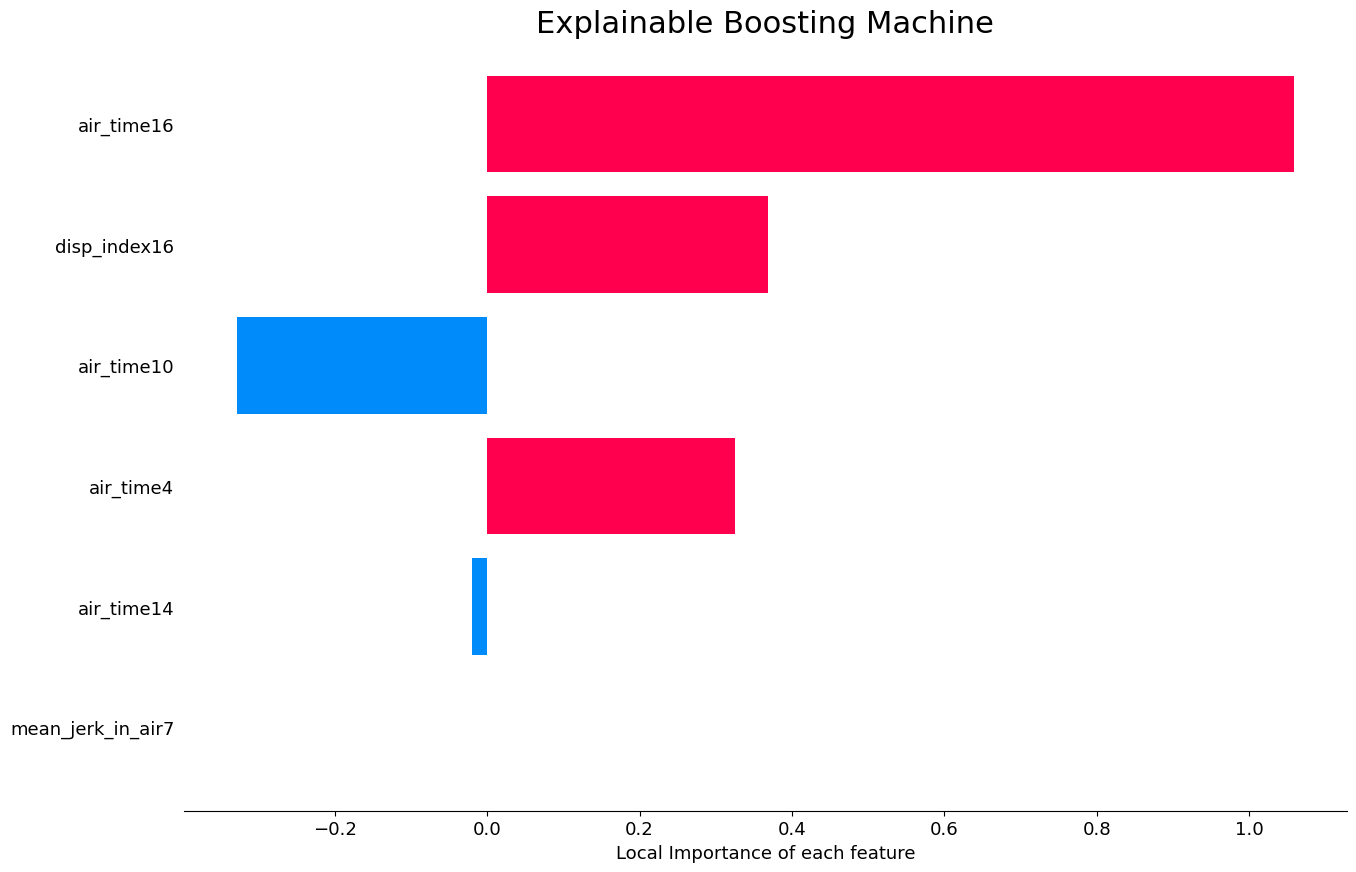

In [1687]:
explanations = [shap.Explanation(lr_shap_loc_values[1, :], lr_SHAP_exp.expected_value[1], data=Exp_inst_pd),
                shap.Explanation(rf_shap_loc_values[1, :], rf_SHAP_exp.expected_value[1], data=Exp_inst_pd),
                shap.Explanation(svm_shap_loc_values[1, :], svm_SHAP_exp.expected_value[1], data=Exp_inst_pd)]

visual.local_shap(explanations, 
                  ebm_local.data(key=Exp_index),
                  nrows = 2,
                  ncols = 2,
                  figsize = (15,10),
                  title_size = 22,
                  label_size = label_size,
                  titles = ["Logistic Regression", "Random Forest", "Support Vector Machines"],
                  ebm_colors = shap_colors/255,
                  num_features=9,
                  save_name=f"{logs_dir}/darwin_local_SHAP_EBM_{suffix}")

plt.show()


## Global Explanations

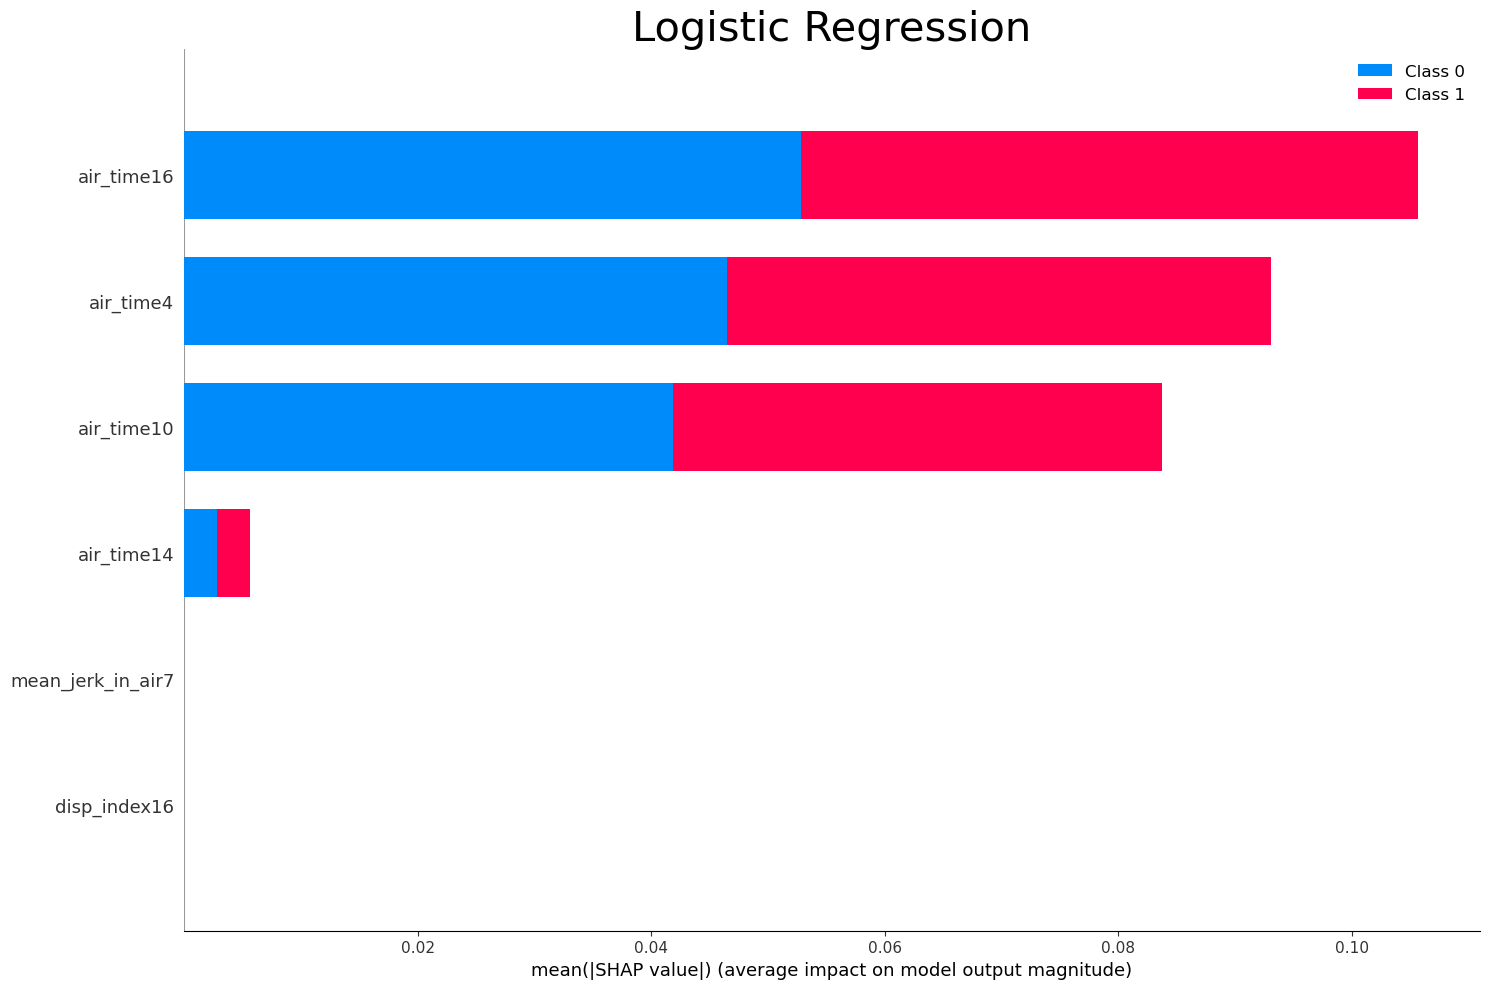

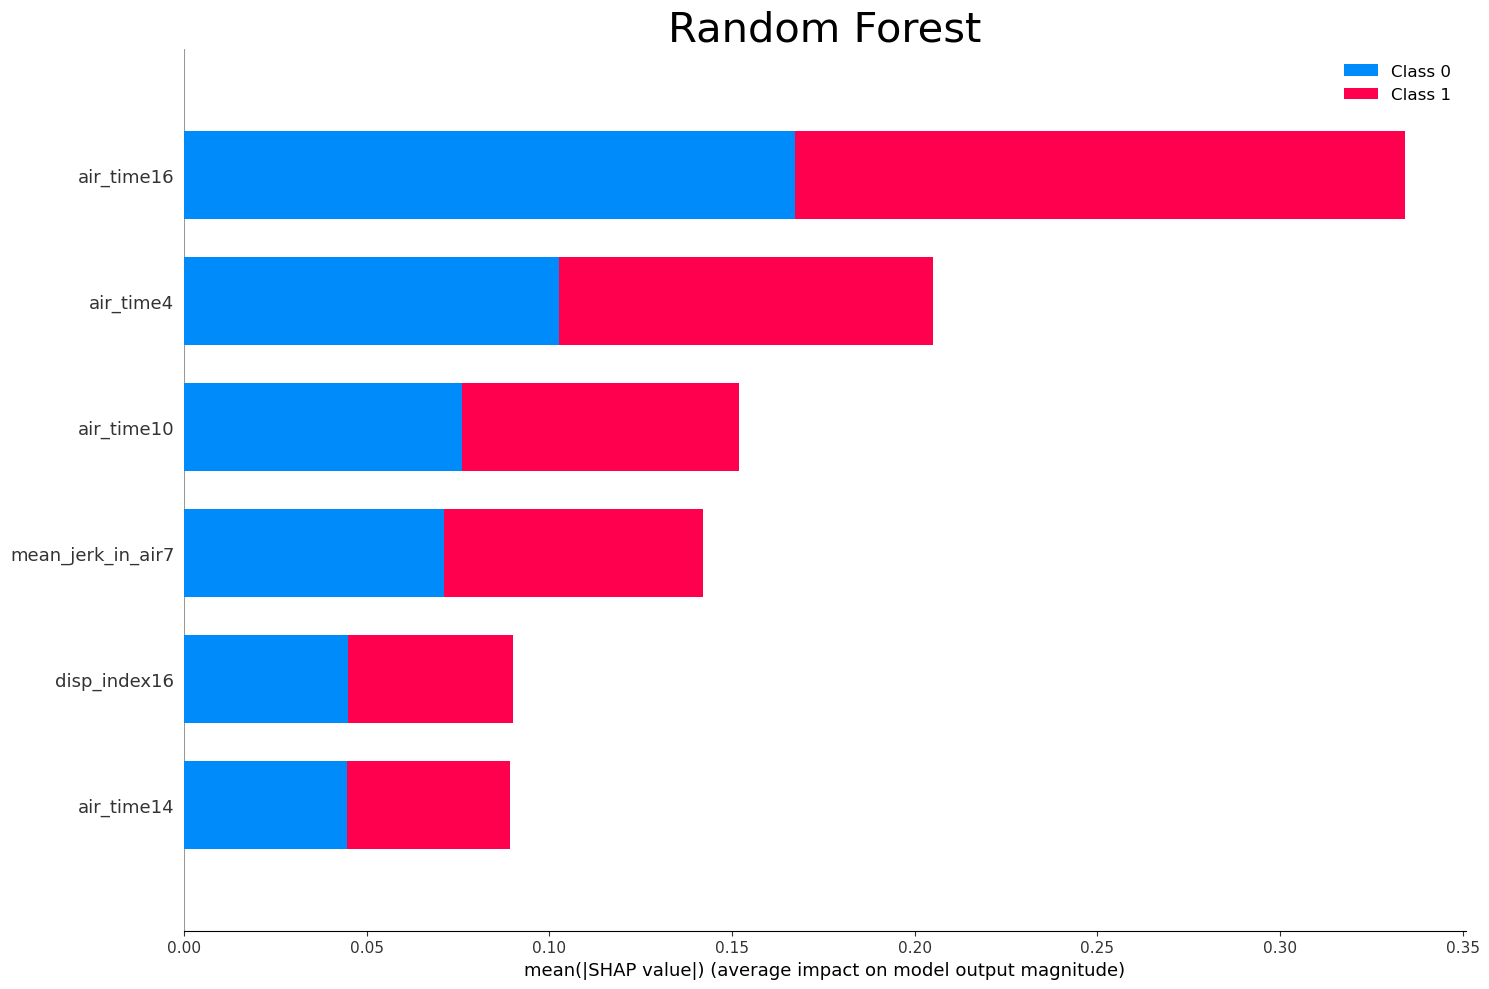

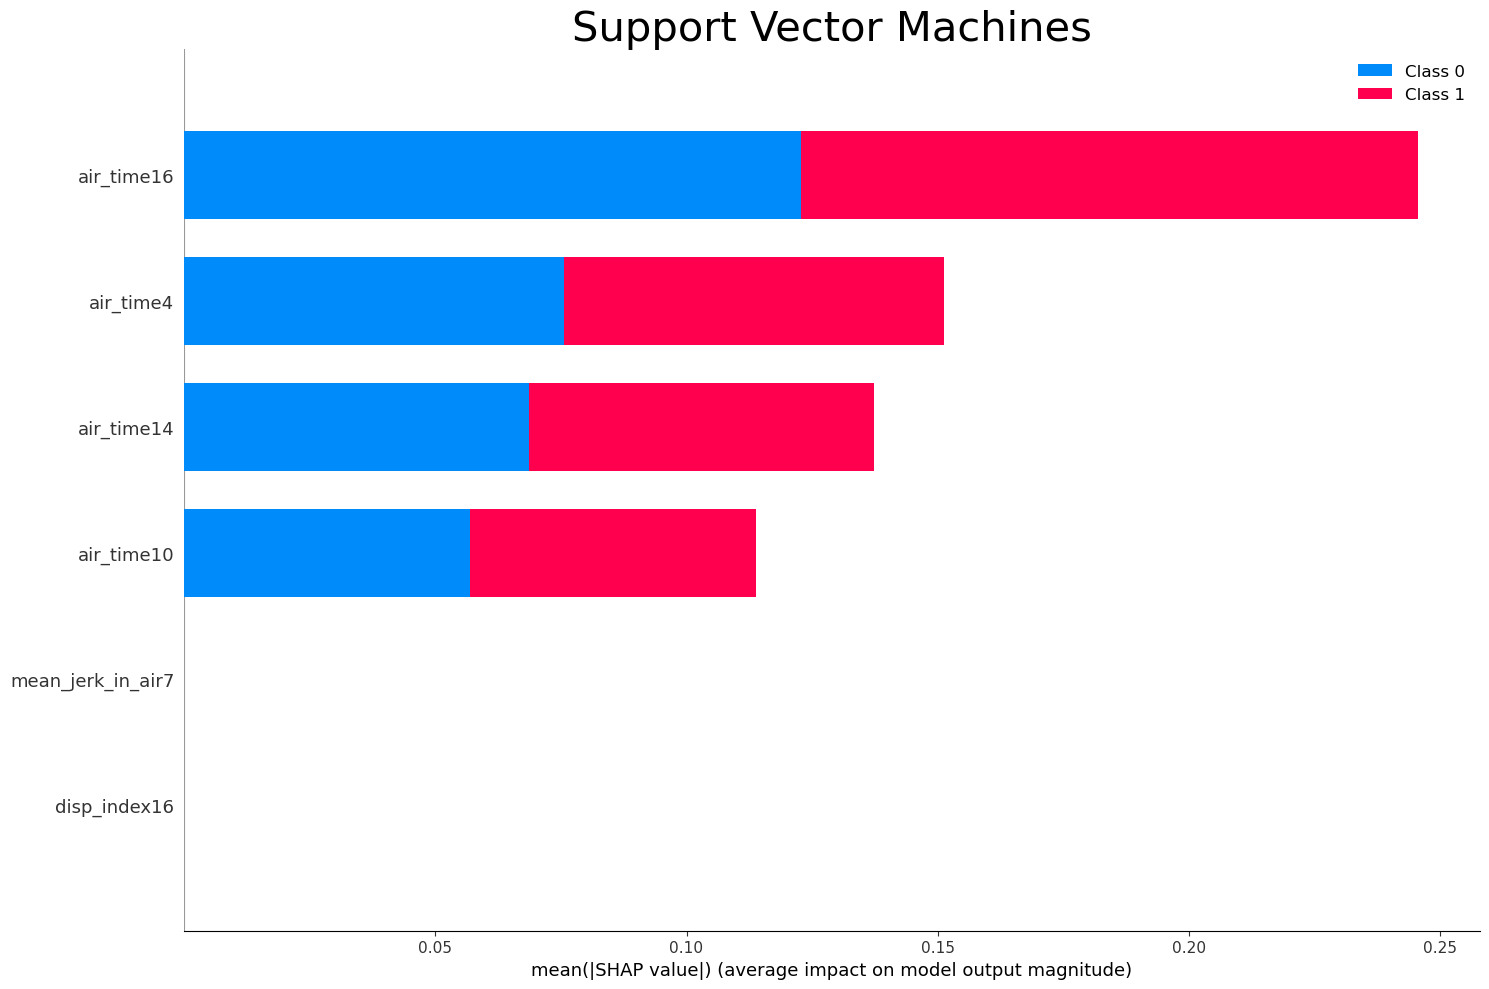

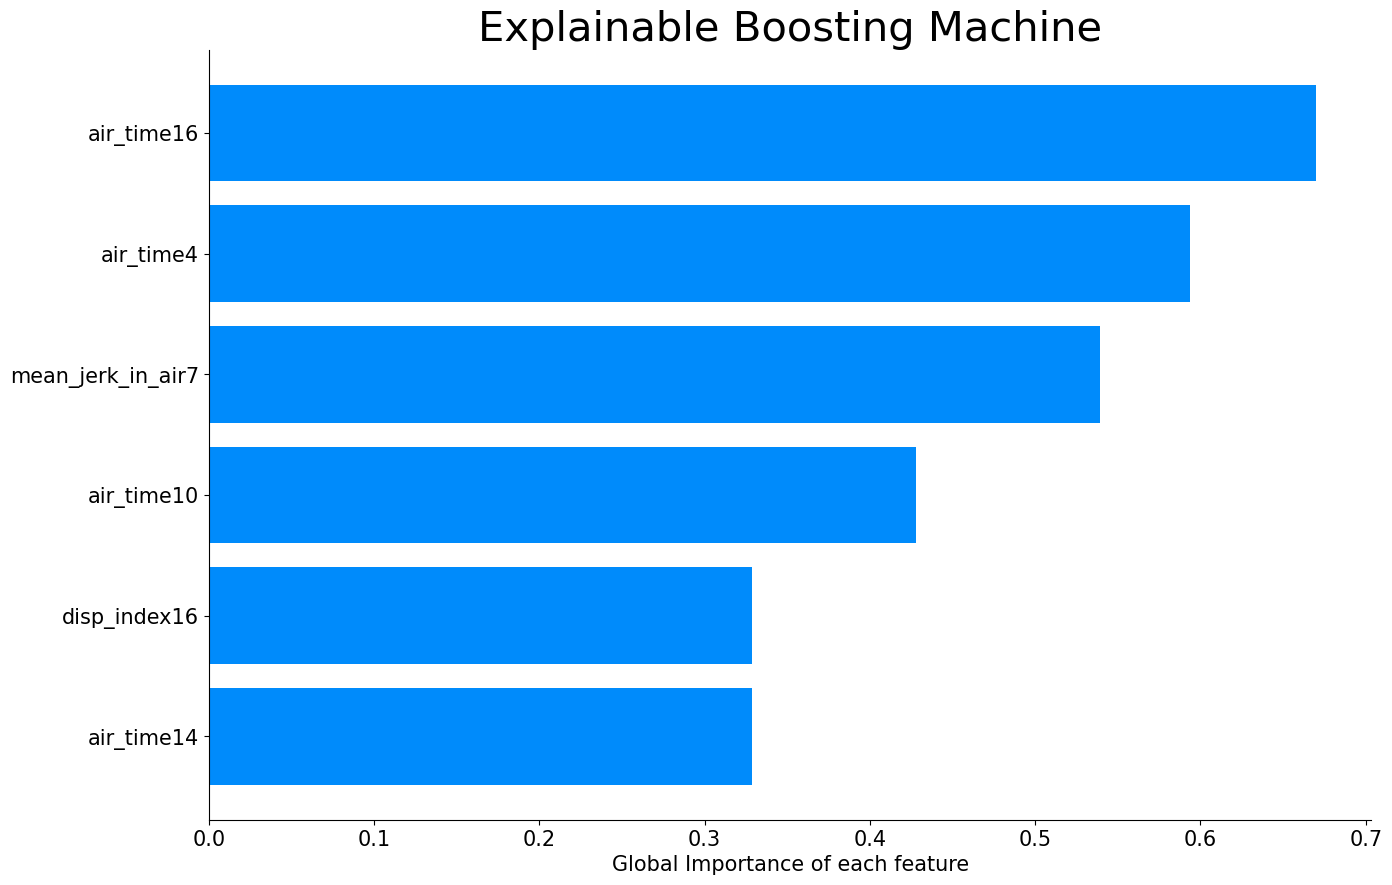

In [1688]:
global_shap_values = [lr_shap_global_values,
                      rf_shap_global_values,
                      svm_shap_global_values]

visual.global_shap(global_shap_values,
                   X_test_pd,
                   ebm_global.data(),
                   nrows = 2,
                   ncols = 2,
                   figsize = (15, 10),
                   title_size = 30,
                   label_size = 15,
                   titles = ["Logistic Regression", "Random Forest", "Support Vector Machines"],
                   ebm_colors = shap_colors/255,
                   num_features=15,
                   save_name=f"{logs_dir}/darwin_global_SHAP_EBM_{suffix}")

plt.show()